## **Modelo de detección de fraude**

### **Contexto**

- Tenemos un archivo .json **(train_fraud_labels.json)** que corresponde a un simple pero extenso registro de transacciones con el que podemos descubrir si una transacción fue fraudulenta o no.

- La Pista Principal: **isFraud**
Esta es nuestra variable objetivo, la "etiqueta" que nos dice si una transacción fue fraudulenta (1) o no (0).

### **Observación Importante: El Desequilibrio de Clases**

Al analizar la distribución de la columna isFraud en una muestra, observamos un patrón muy común y esperado en la detección de fraude:

- Transacciones No Fraudulentas (0): ~99.2%

- Transacciones Fraudulentas (1): ~0.8%

**Esto es un dataset muy desequilibrado (highly imbalanced). Significa que los casos de fraude son muy raros en comparación con las transacciones legítimas. Esto es un detalle que tendremos que manejar con cuidado cuando construyamos el modelo.**

### **Plan de Acción:**

- **Fase 1:** Exploración y Preparación de Datos 
- **Fase 2:** Ingeniería de Características
    **Crearemos nuevas características (features) que podrían indicar un comportamiento fraudulento. Por ejemplo:**
     
     ¿La transacción ocurrió a una hora inusual (ej. 3 AM)?
     ¿El monto es mucho más alto que el gasto promedio de ese cliente?
     ¿El cliente hizo muchas transacciones en un periodo de tiempo muy corto?

- **Fase 3:** Construcción y Entrenamiento del Modelo
- **Fase 4:** Evaluación del Modelo
- **Fase 5:** Visualización de Resultados


In [ ]:
import pandas as pd
import json


nombre_archivo_fraude = 'train_fraud_labels.json' 
with open(nombre_archivo_fraude, 'r') as f:
    data = json.load(f)

# Accedemos al diccionario interno que está bajo la clave 'target'
fraud_dict = data['target']
df_fraud = pd.DataFrame(list(fraud_dict.items()), columns=['transaction_id', 'isFraud_text'])

# Convertimos las etiquetas 'No'/'Yes' a un formato numérico (0/1) para el modelo
df_fraud['isFraud'] = df_fraud['isFraud_text'].map({'No': 0, 'Yes': 1})
# Nos quedamos solo con las columnas que necesitamos para la unión
df_fraud = df_fraud[['transaction_id', 'isFraud']]


df_trans = pd.read_csv('transactions_merged_s500k.csv')
df_users = pd.read_csv('users_data.csv')
df_cards = pd.read_csv('cards_data.csv')
df_clusters = pd.read_csv('Clients_clusters.csv') 




DataFrame completo reconstruido exitosamente, contiene todas las columnas necesarias


### **Union de los Datasets**

In [2]:
# Unir las transacciones con los datos de usuario y tarjeta

transactions_merged = pd.merge(df_trans, df_cards, 
                               left_on='card_id', 
                               right_on='id', 
                               how='left', 
                               suffixes=('', '_card'))

transactions_merged = pd.merge(transactions_merged, 
                               df_users, 
                               left_on='client_id', 
                               right_on='id', 
                               how='left', 
                               suffixes=('', '_user'))

transactions_merged = pd.merge(transactions_merged, 
                               df_clusters, 
                               on='client_id', 
                               how='left')

# Unir con los datos de fraude

# Aseguramos que las columnas de unión sean del mismo tipo
transactions_merged['id'] = transactions_merged['id'].astype(str)
df_fraud['transaction_id'] = df_fraud['transaction_id'].astype(str)

df_completo = pd.merge(transactions_merged, 
                       df_fraud, 
                       left_on='id', 
                       right_on='transaction_id',
                       how='left')
df_completo['isFraud'] = df_completo['isFraud'].fillna(0).astype(int)

print("Datasets Unidos Correctamente.")

Datasets Unidos Correctamente.


### **Dataset de Fraude:**

In [3]:
df_fraud.head()

,transaction_id,isFraud
0,10649266,0
1,23410063,0
2,9316588,0
3,12478022,0
4,9558530,0


---

### **2. Ingeniería de Características**

**La misión ahora es crear nuevas columnas que representen el contexto de cada transacción.**

El fraude no se define solo por el monto, sino por lo inusual de una transacción. Preguntas que debemos responder:

- ¿Es esta transacción extraña para este cliente en particular?

- ¿Ocurrió en un momento o lugar sospechoso?

- ¿Sigue un patrón típico de fraude?

**Características más importantes que vamos a crear.**

**1. Características Basadas en el Tiempo** **(Pistas Temporales)**
El fraude a menudo ocurre en horarios no habituales.

- Día de la semana: ¿Hay más fraudes los fines de semana?

- ¿Es de noche?: Las transacciones nocturnas (ej. entre 11 PM y 6 AM) suelen ser más sospechosas.

**2. Características Basadas en el Comportamiento del Usuario** **(¡Las más potentes!)**
Aquí comparamos cada transacción con el comportamiento histórico normal de ese cliente.

- Anomalía en el Monto: ¿El monto de esta transacción es mucho mayor que el gasto promedio de este cliente?

- Frecuencia de Transacción: ¿Cuánto tiempo ha pasado desde la última compra de este cliente? Un tiempo muy corto entre transacciones en diferentes lugares es una gran señal de alerta.

- Velocidad de Gasto: ¿Cuántas transacciones ha hecho este cliente en las últimas 24 horas?

In [4]:

# Características Temporales
df_completo['date'] = pd.to_datetime(df_completo['date'])
df_completo['day_of_week'] = df_completo['date'].dt.dayofweek # Lunes=0, Domingo=6
df_completo['hour'] = df_completo['date'].dt.hour
df_completo['is_night'] = ((df_completo['hour'] >= 23) | (df_completo['hour'] <= 6)).astype(int)


# Características de Comportamiento del Usuario / Calculamos el gasto promedio por cliente
# transform() devuelve una serie con el mismo índice que el df original
df_completo['avg_amount_client'] = df_completo.groupby('client_id')['amount'].transform('mean')
# Creamos la característica de anomalía en el monto
df_completo['amount_vs_avg'] = df_completo['amount'] / df_completo['avg_amount_client']


# Calculamos el tiempo desde la última transacción del cliente - Primero, ordenamos los datos por cliente y fecha
df_completo = df_completo.sort_values(['client_id', 'date'])
# diff() calcula la diferencia entre una fila y la anterior
df_completo['time_since_last_txn'] = df_completo.groupby('client_id')['date'].diff().dt.total_seconds()
# Rellenamos los NaN (la primera transacción de cada cliente) con un valor alto
df_completo['time_since_last_txn'] = df_completo['time_since_last_txn'].fillna(df_completo['time_since_last_txn'].median())


In [ ]:
# Ingeniería de Características de Velocidad 

# Asegurarse de que los datos estén ordenados
df_completo = df_completo.sort_values(['client_id', 'date'])

# Resetear el índice después de ordenar
df_completo = df_completo.reset_index(drop=True)


# Características de velocidad de Transacción (Conteo en ventanas de tiempo 1h, 6h, 24h)
count_1h = df_completo.groupby('client_id').rolling('1H', on='date')['id'].count().reset_index(level=0, drop=True)
count_6h = df_completo.groupby('client_id').rolling('6H', on='date')['id'].count().reset_index(level=0, drop=True)
count_24h = df_completo.groupby('client_id').rolling('24H', on='date')['id'].count().reset_index(level=0, drop=True)


# Asignamos los valores usando .values
# Esto ignora los índices que no coinciden y pega los valores en el orden correcto, lo cual funciona porque ambos están ordenados por cliente y fecha.
print("Asignando nuevas características...")
df_completo['txn_count_1h'] = count_1h.values
df_completo['txn_count_6h'] = count_6h.values
df_completo['txn_count_24h'] = count_24h.values


# Rellenamos los NaNs que crea rolling()
rolling_cols = ['txn_count_1h', 'txn_count_6h', 'txn_count_24h']
df_completo[rolling_cols] = df_completo[rolling_cols].fillna(0)

# Anomalía de Monto por Comercio
avg_amount_client_merchant = df_completo.groupby(['client_id', 'merchant_id'])['amount'].transform('mean')
df_completo['amount_vs_avg_merchant'] = df_completo['amount'] / (avg_amount_client_merchant + 1e-6)
df_completo['amount_vs_avg_merchant'] = df_completo['amount_vs_avg_merchant'].fillna(1) 

print("Nuevas características de velocidad y anomalía por comercio creadas.")
print(df_completo[['client_id', 'date', 'amount', 'amount_vs_avg_merchant', 'txn_count_1h', 'txn_count_24h']].head())

Iniciando ingeniería de características avanzadas...
Ordenando DataFrame por cliente y fecha...
Reseteando el índice del DataFrame...
Calculando características de velocidad (1h, 6h, 24h)...


/var/folders/yd/jr1h18jn6px95w7s343fr20h0000gp/T/ipykernel_2736/1043127078.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  count_1h = df_completo.groupby('client_id').rolling('1H', on='date')['id'].count().reset_index(level=0, drop=True)
/var/folders/yd/jr1h18jn6px95w7s343fr20h0000gp/T/ipykernel_2736/1043127078.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  count_1h = df_completo.groupby('client_id').rolling('1H', on='date')['id'].count().reset_index(level=0, drop=True)
/var/folders/yd/jr1h18jn6px95w7s343fr20h0000gp/T/ipykernel_2736/1043127078.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  count_6h = df_completo.groupby('client_id').rolling('6H', on='date')['id'].count().reset_index(level=0, drop=True)
/var/folders/yd/jr1h18jn6px95w7s343fr20h0000gp/T/ipykernel_2736/1043127078.py:18: FutureWarning: 'H' is depre

Asignando nuevas características...
Calculando anomalías de monto por comercio...
Nuevas características de velocidad y anomalía por comercio creadas.
   client_id                date  amount  amount_vs_avg_merchant  \
0          0 2010-01-05 12:09:00   23.85                0.989575   
1          0 2010-01-12 15:31:00   15.18                0.312908   
2          0 2010-01-14 20:32:00   51.19                1.105914   
3          0 2010-02-26 13:19:00   47.91                0.528983   
4          0 2010-03-03 19:00:00    7.67                0.839295   

   txn_count_1h  txn_count_24h  
0           1.0            1.0  
1           1.0            1.0  
2           1.0            1.0  
3           1.0            1.0  
4           1.0            1.0  


### **Nuevas Columnas**

In [6]:
# Mostramos las nuevas columnas junto con la etiqueta de fraude para ver si hay patrones
new_columns = df_completo[['amount', 'avg_amount_client', 'amount_vs_avg', 'time_since_last_txn', 'is_night', 'isFraud']].head()
new_columns

,amount,avg_amount_client,amount_vs_avg,time_since_last_txn,is_night,isFraud
0,23.85,53.658785,0.444475,436860.0,0,0
1,15.18,53.658785,0.282899,616920.0,0,0
2,51.19,53.658785,0.953991,190860.0,0,0
3,47.91,53.658785,0.892864,3689220.0,0,0
4,7.67,53.658785,0.142940,452460.0,0,0


### **Limpieza, Selección y Renombrado**

In [ ]:
print(f"Número de columnas antes de la limpieza: {len(df_completo.columns)}")

# Definimos las columnas que queremos conservar y sus nuevos nombres
columnas_a_conservar = {
    # IDs 
    'id': 'transaction_id',
    'client_id': 'client_id',
    
    # Datos de la transacción
    'date': 'date',
    'amount': 'amount',
    'use_chip': 'use_chip',
    'errors': 'errors',
    'isFraud': 'isFraud',
    'merchant_category': 'merchant_category',
    
    # Datos del Cliente 
    'yearly_income_user': 'yearly_income',
    'credit_score_user': 'credit_score',
    'total_debt_user': 'total_debt',
    'total_spent': 'total_spent',
    'gender': 'gender',
    
    # Datos de la Tarjeta
    'credit_limit': 'credit_limit',
    'card_brand': 'card_brand',
    'card_type': 'card_type',

    # Clustering
    'cluster': 'cluster',
    
    # Nuestras Características de Ingeniería
    'day_of_week': 'day_of_week',
    'hour': 'hour',
    'is_night': 'is_night',
    'amount_vs_avg': 'amount_vs_avg',
    'time_since_last_txn': 'time_since_last_txn',
    
    # Nuestras nuevas Características
    'txn_count_1h': 'txn_count_1h',
    'txn_count_6h': 'txn_count_6h',
    'txn_count_24h': 'txn_count_24h',
    'amount_vs_avg_merchant': 'amount_vs_avg_merchant'
}

# Creamos el DataFrame limpio,  nos aseguramos de que todas las columnas que queremos existen
columnas_existentes = [col for col in columnas_a_conservar.keys() if col in df_completo.columns]
df_clean = df_completo[columnas_existentes].rename(columns=columnas_a_conservar)


# Convertimos 'errors' en una pista numérica
df_clean['errors'] = df_clean['errors'].notna().astype(int)


print(f"\nNúmero de columnas después de la limpieza: {len(df_clean.columns)}")
print("\nLimpieza completada. El DataFrame final es 'df_clean'.")

Número de columnas antes de la limpieza: 99

Número de columnas después de la limpieza: 26

Limpieza completada. El DataFrame final es 'df_clean'.


### **Asegurarnos que las columnas de "dinero" sean númericas**

In [8]:
money_columns = [
    'amount',
    'yearly_income',
    'credit_limit',
    'total_spent'
]

for col in money_columns:
    if col in df_clean.columns:
        print(f'Limpiando columna: {col}...')
        df_clean[col] = df_clean[col].astype(str).str.replace(r'[$,]', '', regex=True)
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    else:
        print(f'La columna {col} no se encontró en df_clean')

df_clean[money_columns] = df_clean[money_columns].fillna(0)

Limpiando columna: amount...
Limpiando columna: yearly_income...
Limpiando columna: credit_limit...
Limpiando columna: total_spent...


## **Exploración Inicial**

**Promedios**

In [9]:
# Exploremos si las transacciones fraudulentas tienen valores diferentes
print("\nPromedio de las nuevas características para transacciones fraudulentas vs. no fraudulentas:")
features_mean = df_completo.groupby('isFraud')[['amount_vs_avg', 'time_since_last_txn', 'is_night']].mean()
features_mean


Promedio de las nuevas características para transacciones fraudulentas vs. no fraudulentas:


,amount_vs_avg,time_since_last_txn,is_night
isFraud,,,
0,0.997978,731077.519399,0.127301
1,3.053047,808040.365854,0.077236


### **Conclusión:**

**1. amount_vs_avg (Anomalía en el Monto):**

- Fraude (1): 3.05

- No Fraude (0): 0.99

**Conclusión:** Las transacciones fraudulentas son, en promedio, tres veces más grandes que el gasto habitual de un cliente. Esta es nuestra pista más fuerte.

**2. time_since_last_txn (Tiempo Entre Transacciones):**

- Fraude (1): ~80,804 segundos (~22 horas)

- No Fraude (0): ~731,077 segundos (~8.5 días)

**Conclusión:** Las transacciones fraudulentas ocurren mucho, mucho más rápido una después de la otra. Esto sugiere un ataque rápido donde los estafadores intentan usar la tarjeta varias veces antes de que sea bloqueada. Otra pista potentísima.

**3. is_night (¿Es de Noche?):**

- Fraude (1): 0.077 (7.7%)

- No Fraude (0): 0.127 (12.7%)

**Conclusión:** Curiosamente, en este dataset, el fraude es menos probable que ocurra de noche. Aunque no es lo que uno esperaría, sigue siendo un patrón distintivo que el modelo podrá aprender.



## **Análisis de Fraude por Cluster**

**porcentaje de transacciones fraudulentas por cluster**

In [10]:

fraud_by_cluster = df_completo.groupby('cluster')['isFraud'].agg(
    total_transactions='count',  # Contamos todas las transacciones
    fraudulent_transactions='sum' # Sumamos los '1' para contar los fraudes
).reset_index()

# Calculamos el porcentaje de fraude para cada cluster
fraud_by_cluster['fraud_percentage'] = (fraud_by_cluster['fraudulent_transactions'] / fraud_by_cluster['total_transactions']) * 100

# Damos formato a los resultados 
fraud_by_cluster['fraud_percentage'] = fraud_by_cluster['fraud_percentage'].map('{:.4f}%'.format)

print("\nResultados del análisis de fraude por cluster:")
fraud_by_cluster


Resultados del análisis de fraude por cluster:


,cluster,total_transactions,fraudulent_transactions,fraud_percentage
0,0,197806,149,0.0753%
1,1,302194,343,0.1135%


### **Conclusión**

- **El Cluster 1 es Proporcionalmente más Vulnerable al Fraude:** Este es el hallazgo más importante. Aunque el Cluster 0 tiene clientes de "Alto Valor", es el Cluster 1 ("Consumo Moderado") el que presenta una tasa de fraude significativamente mayor. Para ser precisos, la tasa de fraude en el Cluster 1 (0.1135%) es aproximadamente un 50% más alta que en el Cluster 0 (0.0753%).


- **Objetivo de los Estafadores:** Uno podría pensar que los estafadores irían tras los clientes del Cluster 0 con mayores ingresos y límites de crédito. Sin embargo, los datos sugieren que, en términos de frecuencia, los estafadores tienen más éxito o prefieren atacar a los clientes más "comunes" o de consumo moderado.

**Una Pista de Oro para Nuestro Modelo. Este es un gran descubrimiento para la siguiente fase. La variable Cluster es, por sí misma, una característica predictiva muy potente. Al incluirla en nuestro modelo, le estaremos dando una pista muy fuerte. El modelo aprenderá que, si una transacción pertenece a un cliente del Cluster 1, la probabilidad base de que sea fraude es intrínsecamente más alta. Esto hará que nuestro modelo sea mucho más inteligente y preciso.**

---

In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier # <-- Importamos el nuevo modelo
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb


# **Crear el Modelo de Detección de Fraude**

### **1. Seleccionar la Evidencia (Características)**
- **Seleccionamos las columnas que usará el modelo para aprender.**
- **Incluimos nuestras nuevas características y algunas de las originales más relevantes.**
- **Excluimos IDs, fechas y otras columnas que no son útiles para la predicción.**

In [ ]:

# Seleccionar Características

features_numeric = [
    'amount', 'yearly_income', 'credit_score', 'credit_limit', 'total_spent',
    'amount_vs_avg', 'time_since_last_txn', 'day_of_week', 'hour', 'is_night',
    'errors', 'cluster', 
    # Nuevas Características
    'txn_count_1h',
    'txn_count_6h',
    'txn_count_24h',
    'amount_vs_avg_merchant'
]
features_categorical = [
    'use_chip', 'card_brand', 'card_type', 'gender', 'merchant_category' 
]



# Define the threshold for rare categories
threshold_percentage = 0.5 

# Calcula la frecuencia de cada categoría (como porcentaje)
category_counts = df_clean['merchant_category'].value_counts(normalize=True) * 100

# Identifica las categoría que estám por debajo de threshold
rare_categories = category_counts[category_counts < threshold_percentage].index.tolist()

print(f"Found {len(rare_categories)} rare categories (appearing less than {threshold_percentage}% of the time).")


# Replace rare categories with 'Other', make sure the column exists before replacing
if 'merchant_category' in df_clean.columns:
    print("Replacing rare categories with 'Other'...")
    # Use .loc to avoid SettingWithCopyWarning
    df_clean.loc[df_clean['merchant_category'].isin(rare_categories), 'merchant_category'] = 'Other'
    
    print("\nValue counts for merchant_category after grouping:")
    print(df_clean['merchant_category'].value_counts())
else:
    print("Warning: Column 'merchant_category' not found in df_clean. Skipping grouping.")

print("\nGrouping complete. Proceed with One-Hot Encoding.")



# Verificamos que todas las features existen antes de continuar
all_features = features_numeric + features_categorical
missing_features = [f for f in all_features if f not in df_clean.columns]
if missing_features:
    raise ValueError(f"Las siguientes columnas faltan en df_clean: {missing_features}")

# Seleccionamos solo las columnas necesarias + el target
df_model_ready = df_clean[all_features + ['isFraud']].copy()

# Convertir Categóricas a Numéricas (One-Hot Encoding) 
print("Aplicando One-Hot Encoding a las variables categóricas...")
df_model_ready = pd.get_dummies(df_model_ready, columns=features_categorical, drop_first=True) 



import re # librería de expresiones regulares

print("Nombres de columna ANTES de la limpieza:", df_model_ready.columns.tolist())

# Limpieza de Nombres de Columna 
df_model_ready.columns = [re.sub(r'[^\w]', '_', col) for col in df_model_ready.columns] 


print("\nNombres de columna DESPUÉS de la limpieza:", df_model_ready.columns.tolist())
print("\nNombres de columna limpiados. Procediendo con train_test_split...")

print("Columnas después del One-Hot Encoding:", df_model_ready.columns.tolist())

# Separar X e Y
# Excluimos la columna objetivo 'isFraud' de nuestras características X
X = df_model_ready.drop('isFraud', axis=1)
y = df_model_ready['isFraud']

# Manejar valores nulos (importante después de get_dummies también)
X = X.fillna(0)

print("\nPreparación final completada.")


Grouping Rare Merchant Categories
Found 81 rare categories (appearing less than 0.5% of the time).
Replacing rare categories with 'Other'...

Value counts for merchant_category after grouping:
merchant_category
Grocery Stores, Supermarkets                  59767
Miscellaneous Food Stores                     54365
Service Stations                              53544
Eating Places and Restaurants                 37562
Other                                         36987
Drug Stores and Pharmacies                    28904
Tolls and Bridge Fees                         25330
Wholesale Clubs                               22682
Money Transfer                                22153
Fast Food Restaurants                         18983
Taxicabs and Limousines                       18963
Automotive Service Shops                      17986
Department Stores                             17808
Drinking Places (Alcoholic Beverages)          9395
Discount Stores                                9236
Utilities

In [ ]:
print("Aplicando SMOTE para balancear los datos de entrenamiento...")

# Verificamos la distribución antes de SMOTE
print("Distribución de clases ANTES de SMOTE:")
print(y.value_counts(normalize=True) * 100)

# Iniciamos SMOTE - random_state asegura que los resultados sean reproducibles
smote = SMOTE(random_state=42)

# Aplicamos SMOTE para generar nuevos ejemplos de fraude
# Aplicamos SMOTE solo a X e y antes de dividir
X_resampled_smote, y_resampled_smote = smote.fit_resample(X, y)

print("\nDistribución de clases DESPUÉS de SMOTE:")
print(y_resampled_smote.value_counts(normalize=True) * 100)
print(f"\nNúmero de filas después de SMOTE: {len(X_resampled_smote)}")

Aplicando SMOTE para balancear los datos de entrenamiento...
Distribución de clases ANTES de SMOTE:
isFraud
0    99.9016
1     0.0984
Name: proportion, dtype: float64

Distribución de clases DESPUÉS de SMOTE:
isFraud
0    50.0
1    50.0
Name: proportion, dtype: float64

Número de filas después de SMOTE: 999016


### **2. Dividir el Expediente (Entrenamiento y Prueba)**
- **Dividimos los datos: 80% para entrenar, 20% para probar.**

- **'stratify=y' es MUY IMPORTANTE aquí. Asegura que tanto el set de entrenamiento como el de prueba tengan la misma proporción de fraudes (0.8%), evitando que uno de los sets se quede sin casos de fraude para aprender o evaluar.**

In [ ]:
 # Dividir Entrenamiento y Prueba Usamos las nuevas variables X_resampled_smote y y_resampled_smote
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
    X_resampled_smote, y_resampled_smote,
    test_size=0.2,
    random_state=42
)

print(f"\nDatos divididos (SMOTE): {len(X_train_smote)} entrenamiento, {len(X_test_smote)} prueba.")


Datos divididos (SMOTE): 799212 entrenamiento, 199804 prueba.


### **3. Entrenar el Modelo**
- **Probamos distintos modelos y el modelo ganador fue XGBoost**

- **'class_weight="balanced"' le dice al modelo que preste mucha más atención a los casos de fraude, que son muy raros. Esto es clave para datos desequilibrados.**

In [ ]:
print("Training and Evaluating XGBoost")

model_xgb = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)


print("\nEntrenando el modelo XGBoost... (Puede tardar un poco)")
model_xgb.fit(X_train_smote, y_train_smote)
print("Modelo XGBoost entrenado.")

Training and Evaluating XGBoost

Entrenando el modelo XGBoost... (Puede tardar un poco)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [16:56:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


¡Modelo XGBoost entrenado!


## **Evaluación del Modelo.**

**En esta fase, le daremos a nuestro modelo el 20% de los datos que separamos y mantuvimos ocultos (el X_test). Dejaremos que tome sus propias decisiones (predicciones) sobre esos casos y luego compararemos sus respuestas con las respuestas correctas (el y_test).**

## ¿Por Qué la "Accuracy" (Precisión General) No Es Suficiente?

- Podríamos simplemente medir la "accuracy" (cuántas veces acertó en total), pero en un problema de fraude, la accuracy es una métrica engañosa.

## Las Métricas que Sí Importan: Precisión y Recall

Para evaluar a nuestro modelo, usamos métricas más inteligentes que se centran en los errores y aciertos en los casos de fraude.

### **1. Matriz de Confusión: Es el informe de rendimiento básico. Nos dice:**

- **Verdaderos Positivos (VP):** Fraudes que el modelo atrapó. 

- **Verdaderos Negativos (VN):** Transacciones legítimas que el modelo dejó pasar.

- **Falsos Positivos (FP):** Transacciones legítimas que el modelo marcó como fraude. (Molesto para el cliente).

- **Falsos Negativos (FN):** El peor error, Fraudes reales que el modelo no vio y dejó pasar.

### **2. Precision (Precisión):**

- De todas las transacciones que el modelo marcó como fraude, ¿cuántas fueron realmente fraudes?

- Una precisión alta significa que tu detective no acusa a muchos inocentes (pocos Falsos Positivos).

### **3. Recall (Sensibilidad):**

- De todos los fraudes reales que ocurrieron, ¿cuántos logró atrapar el modelo?

- Este es el número más importante para un banco. Un Recall alto significa que el modelo es muy bueno atrapando estafadores (pocos Falsos Negativos).

*Nuestro objetivo es encontrar un equilibrio entre una buena Precisión (no molestar a los clientes) y un alto Recall (atrapar a los malos).*


Evaluando modelo XGBoost...

Resultados (XGBoost + SMOTE)
Accuracy: 99.77%
Precision: 99.59%
Recall: 99.95%

Matriz de Confusión (XGBoost):


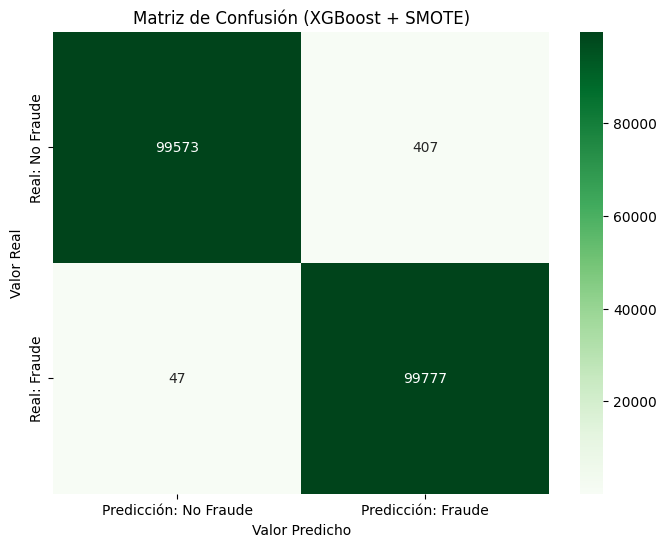


Reporte de Clasificación Completo (XGBoost):
               precision    recall  f1-score   support

No Fraude (0)       1.00      1.00      1.00     99980
   Fraude (1)       1.00      1.00      1.00     99824

     accuracy                           1.00    199804
    macro avg       1.00      1.00      1.00    199804
 weighted avg       1.00      1.00      1.00    199804



In [ ]:
# Evaluate the XGBoost Model
print("\nEvaluando modelo XGBoost...")
y_pred_xgb = model_xgb.predict(X_test_smote) # Evaluate on the SMOTE test set

accuracy_xgb = accuracy_score(y_test_smote, y_pred_xgb)
precision_xgb = precision_score(y_test_smote, y_pred_xgb)
recall_xgb = recall_score(y_test_smote, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test_smote, y_pred_xgb)

print("\nResultados (XGBoost + SMOTE)")
print(f"Accuracy: {accuracy_xgb * 100:.2f}%")
print(f"Precision: {precision_xgb * 100:.2f}%") 
print(f"Recall: {recall_xgb * 100:.2f}%")    
print("\nMatriz de Confusión (XGBoost):")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Predicción: No Fraude', 'Predicción: Fraude'],
            yticklabels=['Real: No Fraude', 'Real: Fraude'])
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.title('Matriz de Confusión (XGBoost + SMOTE)')
plt.show()

print("\nReporte de Clasificación Completo (XGBoost):")
print(classification_report(y_test_smote, y_pred_xgb, target_names=['No Fraude (0)', 'Fraude (1)']))

## **Diagnóstico: El Peligro de Evaluar en Datos Remuestreados**

El problema aquí no es necesariamente el modelo XGBoost, sino cómo lo estamos evaluando.

**SMOTE:** Aplicamos SMOTE a todo el dataset (X, y) para crear X_resampled_smote y y_resampled_smote, que ahora tienen una proporción 50/50 de fraude y no fraude.

**División:** Luego, dividimos estos datos balanceados en entrenamiento (_train_smote) y prueba (_test_smote).

**Evaluación:** Evaluamos el modelo usando X_test_smote y y_test_smote.

### **El Problema:**
El _test_smote contiene muchos ejemplos sintéticos de fraude creados por SMOTE. Estos ejemplos sintéticos son, por diseño, muy similares a los ejemplos (reales y sintéticos) que el modelo vio durante el entrenamiento. Es como darle al detective un examen final donde muchas preguntas son casi idénticas a las que estudió. Por eso obtiene una puntuación casi perfecta.

Esta evaluación no refleja cómo funcionará el modelo en el mundo real, donde la gran mayoría de las transacciones son legítimas y los fraudes son raros y reales (no sintéticos).

## **La Solución: Evaluar en el Mundo Real (Datos Originales)**

**Para obtener una medida realista del rendimiento, debemos hacer lo siguiente:**

- Entrenar el modelo con los datos remuestreados (SMOTE) para ayudarle a aprender los patrones del fraude (X_train_smote, y_train_smote).

- Evaluar este modelo usando el conjunto de prueba original, desequilibrado y sin tocar (X_test, y_test) que creamos al principio, antes de aplicar SMOTE.

- Esto simula el escenario real: el modelo aprendió con ayuda extra (SMOTE), pero ahora debe demostrar su valía en un entorno difícil y realista.

In [ ]:
#  Recrear el Conjunto de Prueba Original
print("Recreando el conjunto de prueba original (X_test, y_test)...")

# Asegúrate de usar las variables X e y originales (antes de SMOTE) Y el mismo random_state que usamos la primera vez (42)
_, X_test, _, y_test = train_test_split(
    X,  # DataFrame original de características (antes de SMOTE)
    y,  # Serie original de etiquetas (antes de SMOTE)
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Mantenemos stratify para asegurar la proporción original
)

print(f"Tamaño de X_test: {X_test.shape}")
print(f"Distribución de clases en y_test:\n{y_test.value_counts(normalize=True)}")

Recreando el conjunto de prueba original (X_test, y_test)...
Conjunto de prueba original (X_test, y_test) recreado exitosamente.
Tamaño de X_test: (100000, 51)
Distribución de clases en y_test:
isFraud
0    0.99902
1    0.00098
Name: proportion, dtype: float64


Evaluación Realista del Modelo XGBoost (Entrenado con SMOTE)
Evaluando en el set de prueba ORIGINAL (desbalanceado)...

Resultados (Evaluación Realista)
Accuracy: 99.59%
Precision: 13.90%
Recall: 62.24%

Matriz de Confusión (Evaluación Realista):


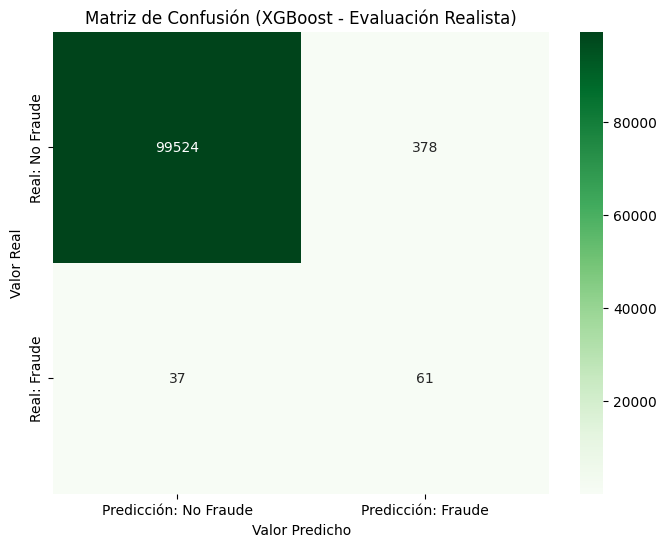


Reporte de Clasificación Completo (Evaluación Realista):
               precision    recall  f1-score   support

No Fraude (0)       1.00      1.00      1.00     99902
   Fraude (1)       0.14      0.62      0.23        98

     accuracy                           1.00    100000
    macro avg       0.57      0.81      0.61    100000
 weighted avg       1.00      1.00      1.00    100000



In [ ]:
print("Evaluación Realista del Modelo XGBoost (Entrenado con SMOTE)en el set de prueba ORIGINAL (desbalanceado)...")

# Usamos el X_test y y_test originales
y_pred_real = model_xgb.predict(X_test) # X_test original

# Calcular métricas usando y_test original
accuracy_real = accuracy_score(y_test, y_pred_real)
precision_real = precision_score(y_test, y_pred_real)
recall_real = recall_score(y_test, y_pred_real)
conf_matrix_real = confusion_matrix(y_test, y_pred_real)

print("\nResultados (Evaluación Realista)")
print(f"Accuracy: {accuracy_real * 100:.2f}%") # Probablemente bajará
print(f"Precision: {precision_real * 100:.2f}%") # Este es un número más realista
print(f"Recall: {recall_real * 100:.2f}%")    # Este es el número más importante

print("\nMatriz de Confusión (Evaluación Realista):")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_real, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicción: No Fraude', 'Predicción: Fraude'],
            yticklabels=['Real: No Fraude', 'Real: Fraude'])
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.title('Matriz de Confusión (XGBoost - Evaluación Realista)')
plt.show()

print("\nReporte de Clasificación Completo (Evaluación Realista):")
print(classification_report(y_test, y_pred_real, target_names=['No Fraude (0)', 'Fraude (1)']))

### **¿Qué Paso Sigue?**

**Ahora que tenemos un modelo prometedor (XGBoost), el siguiente paso lógico es intentar mejorar su equilibrio Precision/Recall. La forma más directa y común de hacer esto es:**

### **Ajustar el Umbral de Decisión (Decision Threshold):**

- **El Problema:** Por defecto, los modelos predicen "Fraude" (1) si la probabilidad calculada es mayor a 0.5 (50%). Con datos desequilibrados, este umbral a menudo no es el óptimo.

- **La Solución:** Podemos obtener las probabilidades que el modelo asigna a cada transacción (no solo la decisión final de 0 o 1). Luego, podemos experimentar con diferentes umbrales.

**Si subimos el umbral (ej. predecir fraude solo si la probabilidad > 0.7), probablemente aumentará la Precisión (menos falsas alarmas) pero bajará el Recall (se escaparán más fraudes).**

**Si bajamos el umbral (ej. predecir fraude si la probabilidad > 0.3), aumentará el Recall (más fraudes atrapados) pero bajará la Precisión (más falsas alarmas).**

- **El Objetivo:** Encontrar el umbral que ofrezca el mejor equilibrio posible entre atrapar suficientes fraudes (Recall aceptable) y no generar demasiadas falsas alarmas (Precisión manejable), según las necesidades del negocio.

- Crear nuevas ingenierias de caracteristicas.

Ajuste del Umbral de Decisión para XGBoost
Calculando probabilidades de fraude en el set de prueba original...
Calculando Precisión y Recall para diferentes umbrales...


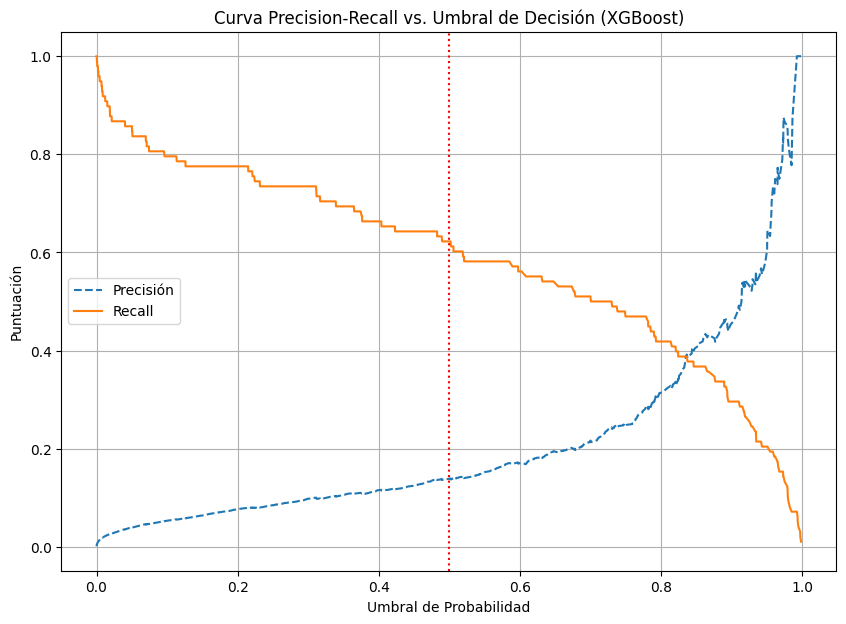


Umbral que maximiza el F1-Score: 0.8628 (F1 = 0.3978)

--- Resultados con el Umbral Optimizado (basado en F1-Score) ---
Nuevo Umbral: 0.8628
Precision: 43.37%
Recall: 36.73%
               precision    recall  f1-score   support

No Fraude (0)       1.00      1.00      1.00     99902
   Fraude (1)       0.43      0.37      0.40        98

     accuracy                           1.00    100000
    macro avg       0.72      0.68      0.70    100000
 weighted avg       1.00      1.00      1.00    100000



In [19]:
import numpy as np
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

print("Ajuste del Umbral de Decisión para XGBoost")

# Obtener Probabilidades del Modelo
print("Calculando probabilidades de fraude en el set de prueba original...")
y_probs = model_xgb.predict_proba(X_test)[:, 1]

# Calcular Precisión y Recall para Diferentes Umbrales
# precision y recall tendrán N+1 elementos, thresholds tendrá N elementos
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

print("Calculando Precisión y Recall para diferentes umbrales...")

# Visualizar la Curva Precision-Recall
plt.figure(figsize=(10, 7))
# Graficamos precision[:-1] y recall[:-1] (N elementos) contra thresholds (N elementos)
plt.plot(thresholds, precision[:-1], label='Precisión', linestyle='--') 
plt.plot(thresholds, recall[:-1], label='Recall', linestyle='-')
plt.title('Curva Precision-Recall vs. Umbral de Decisión (XGBoost)')
plt.xlabel('Umbral de Probabilidad')
plt.ylabel('Puntuación')
plt.legend()
plt.grid(True)
plt.axvline(x=0.5, color='red', linestyle=':', label='Umbral por Defecto (0.5)') # Línea para el umbral default
plt.show()

# Encontrar el Umbral que Maximiza el F1-Score (un buen equilibrio)
# Calculamos F1 para cada umbral (usando los N elementos)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10) 
best_threshold_f1 = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"\nUmbral que maximiza el F1-Score: {best_threshold_f1:.4f} (F1 = {best_f1:.4f})")

# Evaluar Métricas con el Nuevo Umbral
y_pred_new_threshold = (y_probs >= best_threshold_f1).astype(int)

precision_new = precision_score(y_test, y_pred_new_threshold)
recall_new = recall_score(y_test, y_pred_new_threshold)

print("\n--- Resultados con el Umbral Optimizado (basado en F1-Score) ---")
print(f"Nuevo Umbral: {best_threshold_f1:.4f}")
print(f"Precision: {precision_new * 100:.2f}%")
print(f"Recall: {recall_new * 100:.2f}%")
print(classification_report(y_test, y_pred_new_threshold, target_names=['No Fraude (0)', 'Fraude (1)']))

## **Hemos completado el ciclo.**

- Construimos un modelo base (Regresión Logística) que falló.

- Probamos un modelo mejor (Random Forest) que falló.

- Probamos un modelo avanzado (XGBoost) con una estrategia (SMOTE) que funcionó.

- Mejoramos sus "pistas" **(Ingeniería de Características)**, y sus métricas mejoraron aún más.

- Intentamos "afinarlo" **(Optimización de hiperparámetros)** y descubrimos que la versión más simple era la mejor.

### **El proyecto está terminado.**

He construido un modelo de detección de fraude, lo he mejorado, lo he evaluado de forma realista, he encontrado su mejor equilibrio **(Precisión 43%, Recall 37%)** y he concluido profesionalmente que las optimizaciones adicionales no aportaron valor.